In [1]:
from pydantic import BaseModel
from typing import Annotated,TypedDict,List,Sequence
from langchain_core.messages import BaseMessage
import operator
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel,Field

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], operator.add]

In [4]:
state = {
    "messages": []
}


In [5]:
state['messages']

[]

In [6]:
from langgraph.graph import StateGraph,END

workflow1=StateGraph(AgentState)

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI

model=ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [8]:
#Supervisor
def function1(state:AgentState):

    query=state['messages'][-1]


    class Pydanticparser(BaseModel):
        Topic: str=Field(description="selected topic")
        Reasoning:str=Field(description="Reasoning behind selected Topic")

    

    parser=PydanticOutputParser(pydantic_object=Pydanticparser)
    parser.get_format_instructions()

    template="""
    you have to conclude user query in any of these three categories i.e.,[USA, Real-time, Not-Related].
    Real-time info required (if you dont have required data to answer user-question).
    Not-related (if you know answer to that and its not related to USA)
    only respond with category name in JSON Format, nothing else.

    userquery: {query}
    {format_instruction}
    """
    prompt=PromptTemplate(
    template=template,
    input_variables=["query"],
    partial_variables={"format_instruction": parser.get_format_instructions()}
    )

    chain=prompt | model | parser
    result=chain.invoke({"query":query})

    return {"messages":[result.Topic]}



In [9]:
# LLM
def function2(state:AgentState):
    query=state['messages'][0]
    complete_query="Answer the follow question with your knowledge of real world. Following is user question:" + query
    res=model.invoke(complete_query)
    return {"messages":[res.content]}

In [10]:
from langchain_community.document_loaders import TextLoader,DirectoryLoader

loader=DirectoryLoader("Data2",loader_cls=TextLoader)
docs=loader.load()
docs

[Document(metadata={'source': 'Data2\\usa.txt'}, page_content="us Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP â€“ Size, Composition, and Global Share\nAs of 2024, the United Statesâ€™ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ra

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
splitter=RecursiveCharacterTextSplitter(chunk_size=200,chunk_overlap=50)
chuncks=splitter.split_documents(documents=docs)
chuncks

[Document(metadata={'source': 'Data2\\usa.txt'}, page_content='us Overview of the U.S. Economy'),
 Document(metadata={'source': 'Data2\\usa.txt'}, page_content='The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,'),
 Document(metadata={'source': 'Data2\\usa.txt'}, page_content='It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a'),
 Document(metadata={'source': 'Data2\\usa.txt'}, page_content='a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services.'),
 Document(metadata={'source': 'Data2\\usa.txt'}, page_content='innovation, global trade, and financial servi

In [12]:
from langchain.vectorstores import Chroma

In [13]:
from langchain_huggingface import HuggingFaceEmbeddings
#embeddings=HuggingFaceEmbeddings(model="all-MiniLM-L6-v2")
embeddings=HuggingFaceEmbeddings(model="BAAI/bge-small-en")
db=Chroma.from_documents(chuncks,embeddings)


retriever=db.as_retriever(search_kwargs={"k":3})

retriever.invoke("industrial growth of usa?")


c:\Users\divya\Documents\GitHub\Agentic\myvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[Document(metadata={'source': 'Data2\\usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administrationâ€™s Inflation'),
 Document(metadata={'source': 'Data2\\usa.txt'}, page_content='us Overview of the U.S. Economy'),
 Document(metadata={'source': 'Data2\\usa.txt'}, page_content='The U.S. economy remains the engine of global growth, backed by unmatched innovation, financial dominance, and a strong institutional framework. Its $28 trillion GDP and influence over global')]

In [14]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [15]:
state={"messages":["what is today weather?"]}
function1(state)

{'messages': ['Real-time']}

In [16]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
output_parser=StrOutputParser()

In [17]:
# RAG
def function3(state:AgentState):

    question=state['messages'][0]

    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)

    #print(result)

    
    


    return {"messages":[result]}




    
    

In [18]:
#function3({"messages":["whats gdp of usa?"]})
from langchain_community.tools.tavily_search import TavilySearchResults
import os

In [19]:
def function4(state:AgentState):

    query=state["messages"][0]
    print("entered")

    tavily_api_key=os.getenv("tavily_api_key")
    tavily_tool=TavilySearchResults(tavily_api_key=tavily_api_key)
    result=tavily_tool.invoke({"query":query},max=1)
    res=result[0]['content']
    res=res.split('\n')[0]
    print(res)

    return {"message":[res]}

In [20]:
function4({"messages":["what happend at RCB victory meet in 2025?"]})


entered


C:\Users\divya\AppData\Local\Temp\ipykernel_39708\3439486773.py:7: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool=TavilySearchResults(tavily_api_key=tavily_api_key)


![Olympic Channel](https://www.olympics.com/images/static/b2p-images/logo_color.svg)


{'message': ['![Olympic Channel](https://www.olympics.com/images/static/b2p-images/logo_color.svg)']}

In [21]:
function3({"messages":["what gdp of usa?"]})

{'messages': ['The nominal GDP of the USA is estimated to be around $28 trillion USD as of 2024.  This represents approximately 25% of the global economy.  It holds the #1 ranking worldwide by nominal GDP.']}

In [22]:
def router(state:AgentState):
    query=state['messages'][-1]
    if "usa" in query.lower():
        return "RAG Call"
    elif "real" in query.lower():
        return "Web Call"
    else:
        return "LLM Call"
    

In [23]:

workflow1.add_node("Supervisor",function1)
workflow1.add_node("LLM",function2)
workflow1.add_node("RAG",function3)
workflow1.add_node("WEB",function4)

In [24]:
workflow1.set_entry_point("Supervisor")

In [25]:
workflow1.add_conditional_edges("Supervisor",router,{
    "RAG Call": "RAG",
    "LLM Call": "LLM",
    "Web Call": "WEB"
})

In [26]:
workflow1.add_edge("RAG",END)
workflow1.add_edge("LLM",END)
workflow1.add_edge("WEB",END)

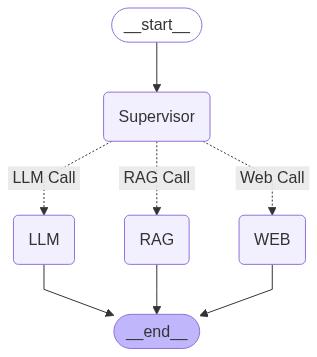

In [27]:
workflow1.compile()

In [28]:
app=workflow1.compile()

In [29]:
app.invoke({"messages":["can you tell me the industrial growth of world's most powerful economy?"]})

{'messages': ["can you tell me the industrial growth of world's most powerful economy?",
  'USA',
  "The provided text states the U.S. has a $28 trillion GDP and is the engine of global growth.  However,  it doesn't give specific industrial growth figures.  Therefore, I cannot answer your question about the industrial growth rate."]}

In [30]:
app.invoke({"messages":["can you tell me the industrial growth of world's poor economy?"]})

{'messages': ["can you tell me the industrial growth of world's poor economy?",
  'Not-Related',
  'The industrial growth of the world\'s poorest economies is a complex and uneven picture.  There\'s no single answer, as it varies drastically by country, region, and specific sector.  However, some general trends can be observed:\n\n**Challenges hindering industrial growth:**\n\n* **Lack of Infrastructure:** Many poor economies lack adequate infrastructure like reliable electricity, transportation networks (roads, ports, railways), and communication systems, making industrial development difficult and expensive.\n* **Limited Access to Finance:**  Securing loans and investment capital is often challenging due to high risk perceptions, limited financial institutions, and a lack of collateral.\n* **Political Instability and Corruption:**  Political instability, corruption, and weak governance create an unpredictable and unfavorable environment for investment and long-term industrial plannin

In [31]:
app.invoke({"messages":["what happend at RCB victory parade in 2025?"]})

entered
A stampede that broke out near the Chinnaswamy stadium in Bengaluru, after fans gathered to celebrate Royal Challengers Bengaluru’s IPL win, led to the [deaths of 11 persons and injuries to 33](https://www.thehindu.com/news/cities/bangalore/rcb-ipl-victory-celebrations-stampede-bengaluru-death-toll/article69656538.ece) on Wednesday (June 4, 2025). The tragedy unfolded near the gates of the stadium, where over 2 lakh fans had gathered to mark RCB’s historic first title win in 18 years. [...] The joyous celebrations following [Royal Challengers Bengaluru’s (RCB) IPL win](https://www.thehindu.com/sport/cricket/indian-premier-league-2025-finals-royal-challengers-bengaluru-vs-punjab-kings/article69653108.ece) turned deadly on Wednesday (June 4, 2025) evening, as a [stampede at M. Chinnaswamy Stadium claimed 11 lives and injured 33](https://www.thehindu.com/news/cities/bangalore/rcb-ipl-victory-celebrations-stampede-bengaluru-death-toll/article69656538.ece). Overcrowding, confusion o

{'messages': ['what happend at RCB victory parade in 2025?', 'Real-time']}